# ROM resolver, ALE helper

In [29]:
import os, json, time, math
import numpy as np
import matplotlib.pyplot as plt
from ale_py import ALEInterface

plt.rcParams["figure.dpi"] = 120

# find ROM dir (set ALE_ROM_DIR if you want a specific path)
if "ALE_ROM_DIR" in os.environ and os.path.exists(os.environ["ALE_ROM_DIR"]):
    ROM_DIR = os.environ["ALE_ROM_DIR"]
else:
    # fallbacks
    try:
        import AutoROM, pathlib
        ROM_DIR = str(pathlib.Path(AutoROM.__file__).parent / "roms")
    except Exception:
        ROM_DIR = os.path.join(os.environ.get("CONDA_PREFIX", ""), "roms")

ROM_PATH = os.path.join(ROM_DIR, "pong.bin")
print("ROM_DIR:", ROM_DIR)
print("pong.bin exists:", os.path.exists(ROM_PATH))
assert os.path.exists(ROM_PATH), "pong.bin not found — set ALE_ROM_DIR correctly."


ROM_DIR: /Users/tonyzh/miniconda3/envs/pong310/lib/python3.10/site-packages/AutoROM/roms
pong.bin exists: True


In [30]:
seed = 0
frameskip = 4  # 4 = faster training; 1 = slower but smoother

ale = ALEInterface()
ale.setInt("random_seed", seed)
ale.setBool("color_averaging", True)
ale.setInt("frame_skip", frameskip)
ale.setFloat("repeat_action_probability", 0.0)
ale.setBool("display_screen", False)
ale.setBool("sound", False)
ale.loadROM(ROM_PATH)

actions = ale.getMinimalActionSet()   # use minimal action set (smaller, easier)
H, W = ale.getScreenGrayscale().shape # should be (210,160)

print("Minimal actions:", len(actions))
print("Gray shape (H,W):", (H, W))


Minimal actions: 6
Gray shape (H,W): (210, 160)


A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
Game console created:
  ROM file:  /Users/tonyzh/miniconda3/envs/pong310/lib/python3.10/site-packages/AutoROM/roms/pong.bin
  Cart Name: Video Olympics (1978) (Atari)
  Cart MD5:  60e0ea3cbe0913d39803477945e9e5ec
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 0


# LFA, Gradient-Free

In [33]:
# features: downsample 210x160 → 42x32 by striding every 5 pixels
# final phi = [downsampled ; frame_diff ; bias]  → 42*32*2 + 1 = 2689
feat_dim = 42*32*2 + 1
n_actions = len(actions)

rng = np.random.default_rng(42)
W_mean = np.zeros((n_actions, feat_dim), dtype=np.float32)   # CEM mean
W_std  = np.full((n_actions, feat_dim), 0.20, dtype=np.float32)  # CEM std (tuneable)

# champion/best tracker
best_score = -1e9
W_best = W_mean.copy()

print("feat_dim:", feat_dim, "| n_actions:", n_actions)

for _ in range(8):
    ale.act(actions[1 if len(actions)>1 else 0])
    if not ale.game_over():
        break

# pre-allocate frame buffers
g_now = np.empty((H, W), dtype=np.uint8)
g_prev = None

# sample random weights around mean/std
W = rng.normal(W_mean, W_std).astype(np.float32)

total = 0.0
steps = 0
max_steps = 20000

# rollout
while (not ale.game_over()) and steps < max_steps:
    ale.getScreenGrayscale(g_now)

    # build features (explicitly, no function)
    ds_now = g_now[::5, ::5].astype(np.float32) / 255.0            # (42,32)
    if g_prev is None:
        diff = np.zeros_like(ds_now)
    else:
        diff = ds_now - (g_prev[::5, ::5].astype(np.float32) / 255.0)
    phi = np.concatenate([ds_now.ravel(), diff.ravel(), np.array([1.0], dtype=np.float32)])

    # linear softmax policy
    z = W @ phi
    z -= z.max()
    p = np.exp(z); p /= p.sum()
    a_idx = int(rng.choice(n_actions, p=p))
    a = actions[a_idx]

    r = ale.act(a)
    total += r
    steps += 1
    g_prev = g_now.copy()

print("Baseline random episode — Return:", total, "Steps:", steps)

# reset env for training loops later
ale.reset_game()
g_prev = None
for _ in range(8): ale.act(actions[1 if len(actions)>1 else 0])


feat_dim: 2689 | n_actions: 6
Baseline random episode — Return: -20.0 Steps: 840


[Gen 1] elite_mean=-17.88 | best=-17.38 | std_mean=0.0104 | mean_steps=908 | cum_steps=36333


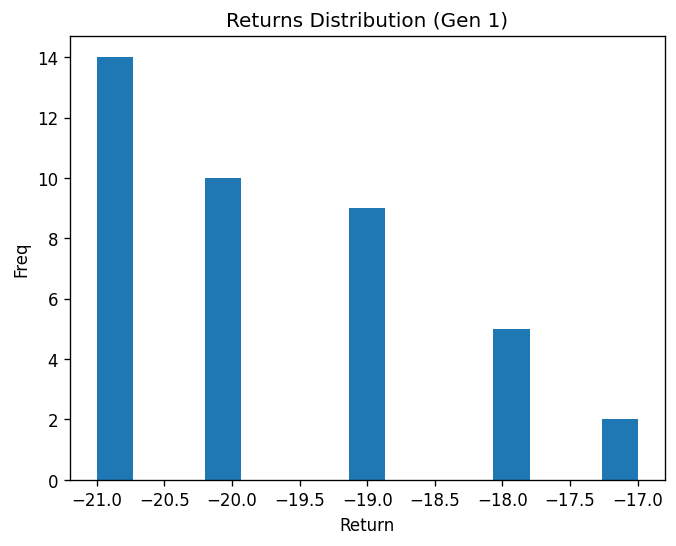

In [69]:
hist_iter = []
hist_elite_mean = []
hist_best = []
hist_std_mean = []
hist_mean_steps = []
hist_cum_steps = []
last_pop_returns = []
hist_pop_mean = []

cum_steps = 0
gen = 0

# CEM hyperparams for this generation
pop_size = 40
elite_frac = 0.2
min_std = 1e-3
eval_episodes = 1  # later: 3 for stability

gen += 1
pop_returns = []
pop_steps = []

# sample a population of weight matrices from current mean/std
Ws = rng.normal(W_mean, W_std, size=(pop_size, n_actions, feat_dim)).astype(np.float32)

for i in range(pop_size):
    # evaluate Ws[i] over eval_episodes episodes (average)
    scores = []
    steps_list = []
    for k in range(eval_episodes):
        # reset a new episode
        ale.reset_game()
        g_prev = None
        for _ in range(8): ale.act(actions[1 if len(actions)>1 else 0])

        total = 0.0
        steps = 0
        while (not ale.game_over()) and steps < max_steps:
            ale.getScreenGrayscale(g_now)

            ds_now = g_now[::5, ::5].astype(np.float32) / 255.0
            if g_prev is None:
                diff = np.zeros_like(ds_now)
            else:
                diff = ds_now - (g_prev[::5, ::5].astype(np.float32) / 255.0)
            phi = np.concatenate([ds_now.ravel(), diff.ravel(), np.array([1.0], dtype=np.float32)])

            z = Ws[i] @ phi
            z -= z.max()
            p = np.exp(z); p /= p.sum()
            a_idx = int(rng.choice(n_actions, p=p))
            r = ale.act(actions[a_idx])

            total += r
            steps += 1
            g_prev = g_now.copy()

        scores.append(total)
        steps_list.append(steps)
    pop_returns.append(np.mean(scores))
    mean_s = int(np.mean(steps_list))
    pop_steps.append(mean_s)
    cum_steps += mean_s

pop_returns = np.array(pop_returns)
pop_steps = np.array(pop_steps)

pop_mean = float(pop_returns.mean())

# select elites
k = max(1, int(elite_frac * pop_size))
elite_idx = np.argsort(pop_returns)[-k:]
elites = Ws[elite_idx]

# update CEM mean/std
W_mean = elites.mean(axis=0)
W_std  = elites.std(axis=0) + min_std

elite_mean = float(pop_returns[elite_idx].mean())
std_mean = float(W_std.mean())
if elite_mean > best_score:
    best_score = elite_mean
    W_best = W_mean.copy()

# log metrics for this generation
hist_iter.append(gen)
hist_elite_mean.append(elite_mean)
hist_best.append(best_score)
hist_std_mean.append(std_mean)
hist_mean_steps.append(float(pop_steps.mean()))
hist_cum_steps.append(cum_steps)
last_pop_returns = pop_returns.tolist()
hist_pop_mean.append(pop_mean)

print(f"[Gen {gen}] elite_mean={elite_mean:.2f} | best={best_score:.2f} | "
      f"std_mean={std_mean:.4f} | mean_steps={pop_steps.mean():.0f} | cum_steps={cum_steps}")

# histogram for this generation
plt.figure()
plt.title(f"Returns Distribution (Gen {gen})")
plt.hist(pop_returns, bins=15)
plt.xlabel("Return"); plt.ylabel("Freq")
plt.show()


# Ploting

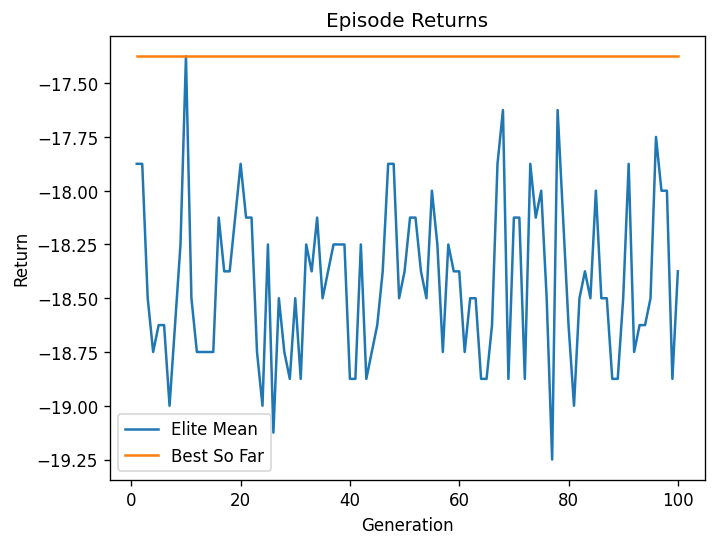

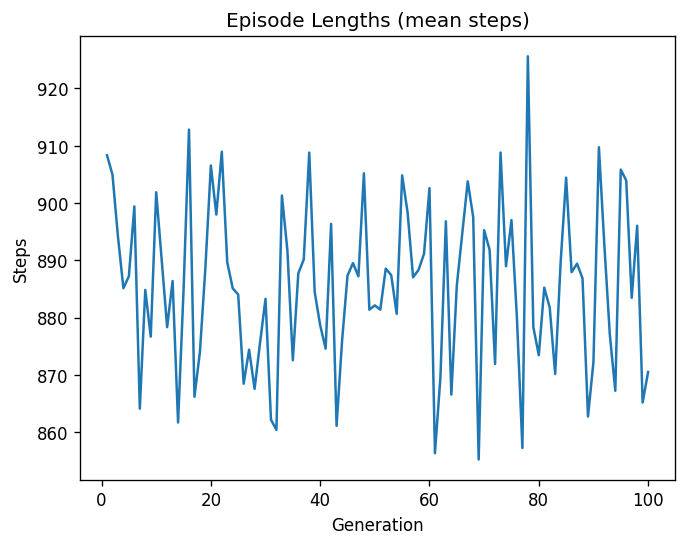

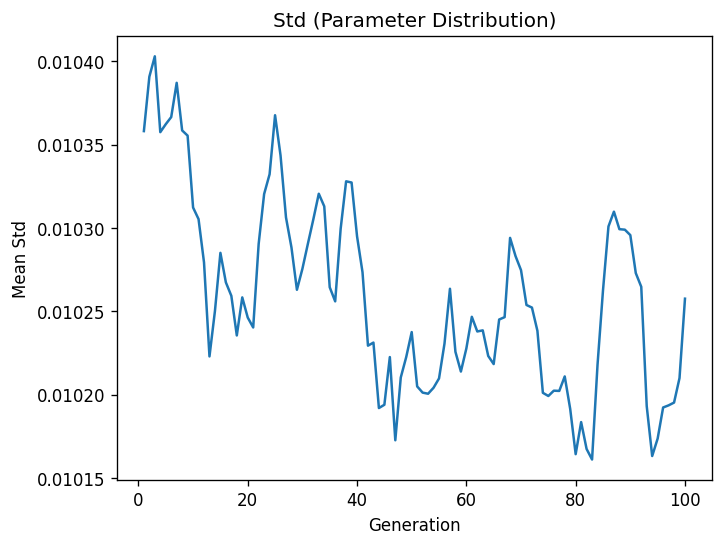

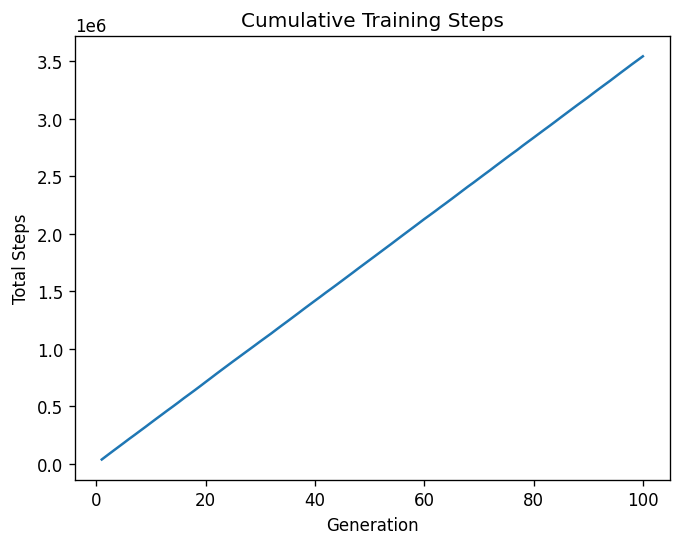

In [76]:
if len(hist_iter) == 0:
    print("no data yet")
else:
    # returns
    x = np.array(hist_iter)

    # Choose a base series for smoothing: prefer population mean if present
    have_pop = 'hist_pop_mean' in globals() and len(hist_pop_mean) == len(hist_iter)
    y_base = np.array(hist_pop_mean) if have_pop else np.array(hist_elite_mean)
    base_label = "Population Mean" if have_pop else "Elite Mean"

    # Exponential Moving Average (EMA) for general growth
    alpha = 0.2  # lower = smoother; try 0.1–0.3
    ema = []
    if len(y_base) > 0:
        s = float(y_base[0])
        for v in y_base:
            s = alpha * float(v) + (1 - alpha) * s
            ema.append(s)
    ema = np.array(ema, dtype=float)

    # 1) Episode Returns (now shows population mean if tracked, elite mean, best, and EMA)
    plt.figure()
    plt.title("Episode Returns")
    if have_pop:
        plt.plot(x, hist_pop_mean, label="Population Mean", alpha=0.6)
    plt.plot(hist_iter, hist_elite_mean, label="Elite Mean")
    plt.plot(hist_iter, hist_best, label="Best So Far")
    plt.xlabel("Generation"); plt.ylabel("Return"); plt.legend(); plt.show()

    # episode lengths
    plt.figure()
    plt.title("Episode Lengths (mean steps)")
    plt.plot(hist_iter, hist_mean_steps)
    plt.xlabel("Generation"); plt.ylabel("Steps"); plt.show()

    # std mean
    plt.figure()
    plt.title("Std (Parameter Distribution)")
    plt.plot(hist_iter, hist_std_mean)
    plt.xlabel("Generation"); plt.ylabel("Mean Std"); plt.show()

    # cumulative steps
    plt.figure()
    plt.title("Cumulative Training Steps")
    plt.plot(hist_iter, hist_cum_steps)
    plt.xlabel("Generation"); plt.ylabel("Total Steps"); plt.show()


In [75]:
N = 90  # ← set how many more gens to do this time

for _ in range(N):
    gen += 1
    pop_returns = []
    pop_steps = []
    Ws = rng.normal(W_mean, W_std, size=(pop_size, n_actions, feat_dim)).astype(np.float32)

    for i in range(pop_size):
        scores = []
        steps_list = []
        for k in range(eval_episodes):
            ale.reset_game()
            g_prev = None
            for _ in range(8): ale.act(actions[1 if len(actions)>1 else 0])

            total = 0.0
            steps = 0
            while (not ale.game_over()) and steps < max_steps:
                ale.getScreenGrayscale(g_now)

                ds_now = g_now[::5, ::5].astype(np.float32) / 255.0
                if g_prev is None:
                    diff = np.zeros_like(ds_now)
                else:
                    diff = ds_now - (g_prev[::5, ::5].astype(np.float32) / 255.0)
                phi = np.concatenate([ds_now.ravel(), diff.ravel(), np.array([1.0], dtype=np.float32)])

                z = Ws[i] @ phi
                z -= z.max()
                p = np.exp(z); p /= p.sum()
                a_idx = int(rng.choice(n_actions, p=p))
                r = ale.act(actions[a_idx])

                total += r
                steps += 1
                g_prev = g_now.copy()

            scores.append(total)
            steps_list.append(steps)
        pop_returns.append(np.mean(scores))
        mean_s = int(np.mean(steps_list))
        pop_steps.append(mean_s)
        cum_steps += mean_s

    pop_returns = np.array(pop_returns)
    pop_steps = np.array(pop_steps)

    k = max(1, int(elite_frac * pop_size))
    elite_idx = np.argsort(pop_returns)[-k:]
    elites = Ws[elite_idx]

    W_mean = elites.mean(axis=0)
    W_std  = elites.std(axis=0) + min_std

    elite_mean = float(pop_returns[elite_idx].mean())
    std_mean = float(W_std.mean())
    if elite_mean > best_score:
        best_score = elite_mean
        W_best = W_mean.copy()

    hist_iter.append(gen)
    hist_elite_mean.append(elite_mean)
    hist_best.append(best_score)
    hist_std_mean.append(std_mean)
    hist_mean_steps.append(float(pop_steps.mean()))
    hist_cum_steps.append(cum_steps)
    last_pop_returns = pop_returns.tolist()

    print(f"[Gen {gen}] elite_mean={elite_mean:.2f} | best={best_score:.2f} | "
          f"std_mean={std_mean:.4f} | mean_steps={pop_steps.mean():.0f} | cum_steps={cum_steps}")


# edited the ploting section and kinda lose all the generation history :( but we have the history best so not bad

[Gen 11] elite_mean=-18.50 | best=-17.38 | std_mean=0.0103 | mean_steps=890 | cum_steps=391870
[Gen 12] elite_mean=-18.75 | best=-17.38 | std_mean=0.0103 | mean_steps=878 | cum_steps=427003
[Gen 13] elite_mean=-18.75 | best=-17.38 | std_mean=0.0102 | mean_steps=886 | cum_steps=462458
[Gen 14] elite_mean=-18.75 | best=-17.38 | std_mean=0.0103 | mean_steps=862 | cum_steps=496925
[Gen 15] elite_mean=-18.75 | best=-17.38 | std_mean=0.0103 | mean_steps=885 | cum_steps=532312
[Gen 16] elite_mean=-18.12 | best=-17.38 | std_mean=0.0103 | mean_steps=913 | cum_steps=568824
[Gen 17] elite_mean=-18.38 | best=-17.38 | std_mean=0.0103 | mean_steps=866 | cum_steps=603471
[Gen 18] elite_mean=-18.38 | best=-17.38 | std_mean=0.0102 | mean_steps=874 | cum_steps=638431
[Gen 19] elite_mean=-18.12 | best=-17.38 | std_mean=0.0103 | mean_steps=889 | cum_steps=673979
[Gen 20] elite_mean=-17.88 | best=-17.38 | std_mean=0.0102 | mean_steps=907 | cum_steps=710241
[Gen 21] elite_mean=-18.12 | best=-17.38 | std_mea

# Save, Record

In [66]:
import os, json, time
os.makedirs("checkpoints", exist_ok=True)

# weights (use W_best if available, fall back to W_mean)
if 'W_best' in globals():
    np.save("checkpoints/W_best.npy", W_best)
else:
    np.save("checkpoints/W_best.npy", W_mean)

np.save("checkpoints/W_mean.npy", W_mean)
np.save("checkpoints/W_std.npy",  W_std)

# scalar state
state_dict = {
    "gen": int(gen),
    "cum_steps": int(cum_steps),
    "best_score": float(best_score),
    "feat_dim": int(feat_dim),
    "n_actions": int(n_actions),
    "frameskip": int(frameskip),
    "max_steps": int(max_steps),
}
with open("checkpoints/state.json", "w") as f:
    json.dump(state_dict, f, indent=2)

# training curves
hist = {
    "iter": hist_iter,
    "elite_mean": hist_elite_mean,
    "best_so_far": hist_best,
    "std_mean": hist_std_mean,
    "mean_steps": hist_mean_steps,
    "cum_steps": hist_cum_steps,
}
if 'hist_pop_mean' in globals(): hist["pop_mean"] = hist_pop_mean
with open("checkpoints/history.json", "w") as f:
    json.dump(hist, f)

print("✔ Saved snapshot to ./checkpoints/")


✔ Saved snapshot to ./checkpoints/


In [68]:
# --- Record a video using training-consistent settings (LFA + frame-diff, frameskip=4, softmax) ---
import os, time
import numpy as np
import imageio.v2 as imageio
from IPython.display import Video, display
from ale_py import ALEInterface

# 0) Load weights
W_eval = np.load("checkpoints/W_best.npy") if os.path.exists("checkpoints/W_best.npy") else (W_best if 'W_best' in globals() else W_mean)
assert W_eval.ndim == 2, f"Expected W shape (n_actions, feat_dim); got {W_eval.shape}"

# 1) ALE configured like training
ale = ALEInterface()
ale.setInt("random_seed", 1234)
ale.setBool("display_screen", False)
ale.setBool("sound", False)
ale.setFloat("repeat_action_probability", 0.0)
ale.setInt("frame_skip", 4)    # << match training
ale.loadROM(ROM_PATH)

actions = ale.getMinimalActionSet()
H, W = ale.getScreenGrayscale().shape
feat_dim = 42*32*2 + 1
assert W_eval.shape == (len(actions), feat_dim), f"Weight shape {W_eval.shape} != ({len(actions)}, {feat_dim})"

def rollout_and_collect(return_only=False, rng=np.random.default_rng(0)):
    # (re)start game and "serve" the ball
    ale.reset_game()
    for _ in range(8):
        ale.act(actions[1 if len(actions)>1 else 0])
        if not ale.game_over(): break

    g_now = np.empty((H, W), dtype=np.uint8)
    g_prev = None
    frames = [] if not return_only else None

    total, steps = 0.0, 0
    max_steps = 20000

    while (not ale.game_over()) and steps < max_steps:
        ale.getScreenGrayscale(g_now)
        ds_now = g_now[::5, ::5].astype(np.float32)/255.0
        if g_prev is None:
            diff = np.zeros_like(ds_now)
        else:
            diff = ds_now - (g_prev[::5, ::5].astype(np.float32)/255.0)
        phi = np.concatenate([ds_now.ravel(), diff.ravel(), np.array([1.0], dtype=np.float32)])

        # softmax sampling (like training)
        z = W_eval @ phi
        z -= z.max()
        p = np.exp(z); p /= p.sum()
        a_idx = int(rng.choice(len(actions), p=p))
        total += ale.act(actions[a_idx])
        steps += 1
        g_prev = g_now.copy()

        if frames is not None:
            rgb = ale.getScreenRGB()  # (210,160,3)
            frames.append(rgb.copy())

    return (total, steps, frames) if frames is not None else (total, steps)

# 2) Try K episodes, keep the best one to record (reduces bad-luck runs)
K = 5
rng = np.random.default_rng(999)
best_R, best_steps, best_frames = -999, 0, None
for k in range(K):
    R, S, F = rollout_and_collect(return_only=False, rng=np.random.default_rng(999+k))
    if R > best_R:
        best_R, best_steps, best_frames = R, S, F
print(f"Selected episode among {K}: Return={best_R:.2f}, Steps={best_steps}")

# 3) Write MP4
os.makedirs("videos", exist_ok=True)
ts = time.strftime("%Y%m%d-%H%M%S")
mp4_path = f"videos/pong_lfa_gen{gen}_R{int(best_R)}_{ts}.mp4"
writer = imageio.get_writer(mp4_path, fps=60, codec="libx264", quality=7)
for frame in best_frames:
    writer.append_data(frame)
writer.close()
print(f"✔ Video saved: {mp4_path}")

# 4) Show inline
display(Video(mp4_path, embed=True, html_attributes="controls loop"))


A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
Game console created:
  ROM file:  /Users/tonyzh/miniconda3/envs/pong310/lib/python3.10/site-packages/AutoROM/roms/pong.bin
  Cart Name: Video Olympics (1978) (Atari)
  Cart MD5:  60e0ea3cbe0913d39803477945e9e5ec
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 1234
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Selected episode among 5: Return=-18.00, Steps=1166
✔ Video saved: videos/pong_lfa_gen600_R-18_20251111-203954.mp4
